# Control co-design and sensitivity analysis of the LUPA’s PTO using WecOptTool

Carlos A. **Michelén~Ströfer**, Michael **Devin**, Ryan G. **Coe**, Courtney **Beringer**, Bret **Bosma**, Daniel **Gaebele**, Giorgio **Bacelli**, and Bryson **Robertson**


In [1]:
import gmsh, pygmsh
import capytaine as cpy
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

#### Float

In [2]:
# mass properties
float_mass_properties = {
    'mass': 248.721,
    'CG': [0.01, 0, 0.06],
    'MOI': [66.1686, 65.3344, 17.16],
}

# mesh
mesh_size_factor = 0.3
r1 = 1.0/2  # top radius
r2 = 0.4/2  # bottom radius
h1 = 0.5  
h2 = 0.21
freeboard = 0.3
r3 = 0.10/2 + 0.05  # hole radius

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    cyl = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    cone = geom.add_cone([0, 0, -h1], [0, 0, -h2], r1, r2)
    geom.translate(cyl, [0, 0, freeboard])
    geom.translate(cone, [0, 0, freeboard])
    hole = True
    if hole:
        tmp = geom.boolean_union([cyl, cone])
        bar = geom.add_cylinder([0, 0, 10], [0,0,-20], r3)
        geom.boolean_difference(tmp, bar)
    else:
        geom.boolean_union([cyl, cone])
    mesh_float = geom.generate_mesh()

# floating body
float_fb = cpy.FloatingBody.from_meshio(mesh_float, name='float')
float_fb.add_translation_dof(name='Heave')

#### Spar

In [3]:
# mass properties
spar_mass_properties = {
    'mass': 175.536,
    'CG': [0, 0, -1.3],
    'MOI': [253.6344, 250.4558, 12.746],
}

# mesh
mesh_size_factor = 0.1
r1 = 0.45/2  # body
r2 = 0.45  # plate
r3 = 0.10/2  # bar
h1 = 1.20  
h2 = 0.01
h3a = 3.684 - 2.05
submergence = 2.05 - h1 - h2

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    body = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    geom.translate(body, [0, 0, -submergence])
    plate = geom.add_cylinder([0, 0, 0], [0, 0, -h2], r2)
    geom.translate(plate, [0, 0, -(submergence+h1)])
    bar = geom.add_cylinder([0, 0, h3a], [0, 0, -(h3a+submergence)], r3)
    geom.boolean_union([bar, body, plate])
    mesh_spar = geom.generate_mesh()

# floating body
spar_fb = cpy.FloatingBody.from_meshio(mesh_spar, name='spar')
spar_fb.add_translation_dof(name='Heave')

#### Combined

In [4]:
# density of fresh water
rho = 1000

# floating body
lupa_fb = float_fb + spar_fb
lupa_fb.name = 'LUPA'

# mass properties float
mass_float = float_mass_properties['mass'] 
cm_float = np.array(float_mass_properties['CG'])
pitch_inertia_float = float_mass_properties['MOI'][1] 

# mass properties spar
mass_spar = spar_mass_properties['mass']  
cm_spar = np.array(spar_mass_properties['CG'])
pitch_inertia_spar = spar_mass_properties['MOI'][1] 

 # mass properties LUPA
lupa_fb.center_of_mass = ((mass_float*cm_float + mass_spar*cm_spar)
                        / (mass_float + mass_spar))
lupa_fb.rotation_center = lupa_fb.center_of_mass

# pitch moment of inertia of LUPA using the parallel axis theorem 
d_float = cm_float[2] - lupa_fb.center_of_mass[2]
d_spar = cm_spar[2] - lupa_fb.center_of_mass[2]
pitch_inertia = (
    pitch_inertia_float + mass_float*d_float**2 + 
    pitch_inertia_spar + mass_spar*d_spar**2
)
inertia = np.diag([mass_float, mass_spar, lupa_fb.disp_mass(), pitch_inertia])

# additional DOFs
lupa_fb.add_translation_dof(name='Surge')
lupa_fb.add_rotation_dof(name='Pitch')

### BEM

In [5]:
# compute hydrodynamic coefficients
f1 = 0.02
nfreq = 50
freq = wot.frequency(f1, nfreq, False)

bem_data = wot.run_bem(lupa_fb, freq)

# hydrostatics
_ = lupa_fb.compute_hydrostatics(rho=rho)
hydrostatic_stiffness = lupa_fb.hydrostatic_stiffness

### PTO

In [6]:
conv_d = 0.0254  # in -> m
conv_m = 0.453592  # lb -> kg
conv_moi = 0.453592 * 0.3048**2  # lb*ft^2 -> kg*m^2
conv_s = 2*np.pi / 60  # rpm -> rad/s

# sprocket
sprockets = {
    '8MX-32S-36': {
        'diameter': 3.208 * conv_d,
        'mass': 1.7 * conv_m,
        'MOI': 0.02 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-33S-36': {
        'diameter': 3.308 * conv_d,
        'mass':  3.31* conv_m,
        'MOI': 0.022 * conv_moi,
        'design': 'AF',
    },
    '8MX-34S-36': {
        'diameter': 3.409 * conv_d,
        'mass': 1.8 * conv_m,
        'MOI': 0.026 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-35S-36': {
        'diameter': 3.509 * conv_d,
        'mass': 3.51 * conv_m,
        'MOI': 0.029 * conv_moi,
        'design': 'AF',
    },
    '8MX-36S-36': {
        'diameter': 3.609 * conv_d,
        'mass': 2.1 * conv_m,
        'MOI': 0.032 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-37S-36': {
        'diameter': 3.709 * conv_d,
        'mass': 3.78 * conv_m,
        'MOI': 0.039 * conv_moi,
        'design': 'AF',
    },
    '8MX-38S-36': {
        'diameter': 3.810 * conv_d,
        'mass': 2.4 * conv_m,
        'MOI': 0.04 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-39S-36': {
        'diameter': 3.910 * conv_d,
        'mass': 3.91 * conv_m,
        'MOI': 0.048 * conv_moi,
        'design': 'AF',
    },
    '8MX-40S-36': {
        'diameter': 4.010 * conv_d,
        'mass': 2.5 * conv_m,
        'MOI': 0.049 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-41S-36': {
        'diameter': 4.110 * conv_d,
        'mass': 4.11 * conv_m,
        'MOI': 0.057 * conv_moi,
        'design': 'AF',
    },
    '8MX-42S-36': {
        'diameter': 4.211 * conv_d,
        'mass': 2.8 * conv_m,
        'MOI': 0.061 * conv_moi,
        'design': 'AF-1',  
    },
    '8MX-45S-36': {
        'diameter': 4.511 * conv_d,
        'mass': 3.8 * conv_m,
        'MOI': 0.09 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-48S-36': {
        'diameter': 4.812 * conv_d,
        'mass': 4.3 * conv_m,
        'MOI': 0.114 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-50S-36': {
        'diameter': 5.013 * conv_d,
        'mass': 5.1 * conv_m,
        'MOI': 0.143 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-53S-36': {
        'diameter': 5.314 * conv_d,
        'mass': 5.5 * conv_m,
        'MOI': 0.169 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-56S-36': {
        'diameter': 5.614 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.221 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-60S-36': {
        'diameter': 6.015 * conv_d,
        'mass': 8.9 * conv_m,
        'MOI': 0.352 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-63S-36': {
        'diameter': 6.316 * conv_d,
        'mass': 10.4 * conv_m,
        'MOI': 0.556 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-67S-36': {
        'diameter': 6.717 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.307 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-71S-36': {
        'diameter': 7.118 * conv_d,
        'mass': 7.0 * conv_m,
        'MOI': 0.365 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-75S-36': {
        'diameter': 7.519 * conv_d,
        'mass': 7.3 * conv_m,
        'MOI': 0.423 * conv_moi, 
        'design': 'DF-1',
    },
    '8MX-80S-36': {
        'diameter': 8.020 * conv_d,
        'mass': 17.9 * conv_m,
        'MOI': 1.202 * conv_moi,  
        'design': 'BF-1',
    },
}

# idler pulleys
idler_pulley = {
    'model': 'Gates 4.25X2.00-IDL-FLAT',
    'diameter': 4.25 * conv_d, 
    'face_width': 2.00 * conv_d,
    'mass': 7.6 * conv_m,
    'max_rpm': 5840,
    'MOI': None,  # Not specified
}

# generator
# Note: Model ADR220-B175 data not listed online, but we have
# spec sheet available on request 
generator = {
    'torque_constant': 8.51,  # N*m/A
    'winding_resistance': 5.87,  # Ω 
    'winding_inductance' : 0.0536,  # H 
    'max_torque': 137.9,  # N*m
    'continuous_torque': 46,  # N*m
    'max_speed': 150 * conv_s,  # rad/s
    'MOI': 1.786e-2,  # kg*m^2 
}

# drivetrain 
def gear_ratio(pulley_radius):
    return 1/pulley_radius  # rad/m 

drivetrain_friction = 0.0 # 0.5  # N*m*s/rad  # this will be estimated experimentally in the future
drivetrain_stiffness = 0  # N*m/rad 
# estimated based on mass, assumed to be a disk:
idler_pulley['MOI'] = 0.5 * idler_pulley['mass'] * (idler_pulley['diameter']/2)**2  # kg*m^2

# impedance model
def pto_impedance(sprocket_model, omega=bem_data.omega.values):
    pulley_ratio = sprockets[sprocket_model]['diameter'] / idler_pulley['diameter']
    drivetrain_inertia = (
        generator['MOI'] + 
        sprockets[sprocket_model]['MOI'] + 
        2 * idler_pulley['MOI']*pulley_ratio**2
    )  # N*m^2
    drivetrain_impedance = (
        1j*omega*drivetrain_inertia + 
        drivetrain_friction + 
        1/(1j*omega)*drivetrain_stiffness
    ) 
    winding_impedance = (generator['winding_resistance']
                       + 1j*omega*generator['winding_inductance']
    )
    pulley_radius = sprockets[sprocket_model]['diameter'] / 2
    pto_impedance_11 = -1* gear_ratio(pulley_radius)**2 * drivetrain_impedance
    off_diag = -1*np.ones(omega.shape) * (
        np.sqrt(3.0/2.0) * generator['torque_constant'] * gear_ratio(pulley_radius) + 0j)
    pto_impedance_12 = off_diag 
    pto_impedance_21 = off_diag
    pto_impedance_22 = winding_impedance
    impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])
    return impedance

# PTO object
name = ["PTO_Heave",]
kinematics = np.array([[1, -1, 0, 0],])
pto_ndof = 1
controller = None
loss = None
default_sprocket = '8MX-50S-36'
pto = wot.pto.PTO(pto_ndof,
                  kinematics,
                  controller,
                  pto_impedance(default_sprocket),
                  loss,
                  name)

### Constraints

In [7]:
## Displacements
# maximum stroke
stroke_max = 0.5  # m
def const_stroke_pto(wec, x_wec, x_opt, waves): 
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
    return stroke_max - np.abs(pos.flatten())

## GENERATOR
# peak torque
default_radius = sprockets[default_sprocket]['diameter'] / 2
def const_peak_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
    """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    return generator['max_torque'] - np.abs(torque.flatten())

# continuous torque
def const_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """RMS torque must not exceed max continous torque 
        Tmax_conti - Trms >=0 """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    torque_rms = np.sqrt(np.mean(torque.flatten()**2))
    return generator['continuous_torque'] - torque_rms

# max speed
def const_speed_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
    return generator['max_speed'] - np.abs(rot_vel.flatten())

## Constraints
constraints = [
    {'type': 'ineq', 'fun': const_stroke_pto},
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'ineq', 'fun': const_torque_pto},
    {'type': 'ineq', 'fun': const_speed_pto},
]
nsubsteps = 5

### Mooring

In [8]:
pretension = 285 # N
init_fair_coords = np.array([[-0.19, -0.19, -0.228],
                             [-0.19,  0.19, -0.228],
                             [ 0.19, -0.19, -0.228],
                             [ 0.19,  0.19, -0.228]]) # m
anch_coords = np.array([[-1.95, -1.6, -0.368],
                        [-1.95,  1.6, -0.368],
                        [ 1.95, -1.6, -0.368],
                        [ 1.95,  1.6, -0.368]]) # m
line_ax_stiff = 963. # N/m

# mooring matrix
def k_mooring(fair_coords, anch_coords, pretension, k_ax, nlines):
    """Calculates the 7DOF effective stiffness matrix of a symmetric taut
    mooring system using an analytical solution.
    """

    theta = np.arctan(
        (fair_coords[2] - anch_coords[2])**2
      / np.sqrt(((fair_coords[0] - anch_coords[0])**2
               + (fair_coords[1] - anch_coords[1])**2)))
    linelen = np.sqrt((fair_coords[0] - anch_coords[0])**2
                + (fair_coords[1] - anch_coords[1])**2
                + (fair_coords[2] - anch_coords[2])**2)
    fair_r = np.sqrt(fair_coords[0]**2 + fair_coords[1]**2)
    fair_z = -fair_coords[2]
    k_hh = 0.5 * nlines * (
        pretension / linelen * (1 + np.sin(theta)**2)
        + k_ax * np.cos(theta)**2)
    k_rh = nlines * (
        pretension / (2*linelen) * (fair_z * (1 + np.sin(theta)**2)
        + fair_r * np.sin(theta) * np.cos(theta))
        + 0.5 * k_ax * (fair_z * np.cos(theta)**2
        - fair_r * np.sin(theta) * np.cos(theta)))
    k_vv = nlines * (pretension / linelen *
        np.cos(theta)**2 + k_ax * np.sin(theta)**2)
    k_rr = nlines * (
        pretension * (fair_z * np.sin(theta) + 0.5 * fair_r * np.cos(theta))
        + (0.5 * pretension / linelen * ((fair_r * np.cos(theta) + fair_z * np.sin(theta))**2
        + fair_z**2))
        + 0.5 * k_ax * (fair_z * np.cos(theta) - fair_r*np.sin(theta))**2)
    k_tt = nlines * (
        pretension * fair_r / linelen * (fair_r + linelen*np.cos(theta)))
    mat = np.zeros([7, 7])
    mat[1, 1] = k_vv
    mat[2, 2] = k_hh
    mat[3, 3] = k_hh
    mat[4, 4] = k_rr
    mat[5, 5] = k_rr
    mat[6, 6] = k_tt
    mat[2, 5] = -k_rh
    mat[5, 2] = -k_rh
    mat[4, 3] = k_rh
    mat[3, 4] = k_rh

    return mat

M = k_mooring(init_fair_coords[0, :], anch_coords[0, :], pretension,
              line_ax_stiff, init_fair_coords.shape[0])
ind_4dof = np.array([0, 1, 2, 5])
M_4dof = M[np.ix_(ind_4dof, ind_4dof)]

# mooring
M = xr.DataArray(M_4dof,
                 coords=[bem_data.coords['influenced_dof'],
                 bem_data.coords['radiating_dof']],
                 dims=['influenced_dof', 'radiating_dof'])
moor = ((M + 0j).expand_dims({"omega": bem_data.omega}))
tmp = moor.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
moor = xr.concat([tmp, moor], dim='omega') 
moor = moor.transpose("radiating_dof", "influenced_dof", "omega")
moor = -1*moor  # RHS of equation: -ma = Σf 
mooring_force = wot.force_from_rao_transfer_function(moor, True)

### WEC

In [9]:
# additional forces
f_add = {
    'PTO': pto.force_on_wec,
    'Mooring': mooring_force
}

# small amount of friction to avoid small/negative terms
friction = np.diag([2.0, 2.0, 2.0, 0])

# WEC
wec = wot.WEC.from_bem(bem_data,
                       inertia_matrix=inertia,
                       hydrostatic_stiffness=hydrostatic_stiffness,
                       constraints=constraints,
                       friction=friction,
                       f_add=f_add,
                       dof_names=bem_data.influenced_dof.values,
)

### Waves


In [10]:
waves = {}

# regular (for testing/setup)
amplitude = 0.1
wavefreq = 0.4
phase = 0
wavedir = 0
waves['regular'] = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

# irregular wave cases from OSU
wave_cases = {
    'south_max_90': {'Hs': 0.21, 'Tp': 3.09}, 
    'south_max_annual': {'Hs': 0.13, 'Tp': 2.35},
    'south_max_occurrence': {'Hs': 0.07, 'Tp': 1.90},
    'south_min_10': {'Hs': 0.04, 'Tp': 1.48},  
    'north_max_90': {'Hs': 0.25, 'Tp': 3.46}, 
    'north_max_annual': {'Hs': 0.16, 'Tp': 2.63},
    'north_max_occurrence': {'Hs': 0.09, 'Tp': 2.13},
    'north_min_10': {'Hs': 0.05, 'Tp': 1.68}, 
}

def irregular_wave(hs, tp):
    fp = 1/tp
    spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, hs)
    efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
    return wot.waves.long_crested_wave(efth)

for case, data in wave_cases.items():
    waves[case] = irregular_wave(data['Hs'], data['Tp'])

## Section III-A: Sensitivity analysis

#### Solve inner loop for default design

In [11]:
# Objective function
obj_fun = pto.average_power
nstate_opt = wec.ncomponents

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves['south_max_occurrence'],
    obj_fun, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)

print(f'Optimal average electrical power: {results.fun} W')

# Post-process
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results, waves['south_max_occurrence'], nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves['south_max_occurrence'], nsubsteps)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.014210185456688016
            Iterations: 88
            Function evaluations: 89
            Gradient evaluations: 88
Optimal average electrical power: -1.4210185456688016 W


#### Sensitivities

In [13]:
ndof = len(bem_data.radiating_dof)
x_wec, x_opt = wot.decompose_state(results.x, ndof, nfreq)
nsubsteps = 1

sprocket_model = default_sprocket

inputs = [
    sprockets[sprocket_model]['diameter'],
    sprockets[sprocket_model]['MOI'],
    idler_pulley['diameter'],
    idler_pulley['MOI'],
    generator['MOI'],
    generator['winding_resistance'],
    generator['winding_inductance'],
    generator['torque_constant'],
]

def average_power(
        sprocket_diameter, 
        sprocket_moi, 
        idler_pulley_diameter, 
        idler_pulley_moi,
        generator_moi,
        generator_winding_resistance,
        generator_winding_inductance,
        generator_torque_constant,
        omega = bem_data.omega.values,
        nsubsteps = nsubsteps,
        wec = wec, 
        x_wec = x_wec, 
        x_opt = x_opt,
        pto_ndof = pto_ndof, 
        kinematics = kinematics, 
        controller = controller, 
        loss = loss, 
    ):
    pulley_ratio = sprocket_diameter / idler_pulley_diameter
    drivetrain_inertia = (
        generator_moi + 
        sprocket_moi + 
        2 * idler_pulley_moi*pulley_ratio**2
    )  # N*m^2
    drivetrain_impedance = (
        1j*omega*drivetrain_inertia + 
        drivetrain_friction + 
        1/(1j*omega)*drivetrain_stiffness
    ) 
    winding_impedance = (generator_winding_resistance
                       + 1j*omega*generator_winding_inductance
    )
    pulley_radius = sprocket_diameter / 2
    pto_impedance_11 = -1* gear_ratio(pulley_radius)**2 * drivetrain_impedance
    off_diag = -1*np.ones(omega.shape) * (
        np.sqrt(3.0/2.0) * generator_torque_constant * gear_ratio(pulley_radius) + 0j)
    pto_impedance_12 = off_diag 
    pto_impedance_21 = off_diag
    pto_impedance_22 = winding_impedance
    impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])
    
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, impedance, loss)
    return pto.average_power(wec, x_wec, x_opt, None, nsubsteps)

dP_dDs = grad(average_power, 0)
dP_dMs = grad(average_power, 1)
dP_dDp = grad(average_power, 2)
dP_dMp = grad(average_power, 3)
dP_dMg = grad(average_power, 4)
dP_dRg = grad(average_power, 5)
dP_dLg = grad(average_power, 6)
dP_dTg = grad(average_power, 7)

P = average_power(*inputs)
print(f'average power: {P} W')

def print_results(func, func_name, units, i):
    dydx = func(*inputs)
    print(f'{func_name}: {dydx} W/{units},   {dydx*(inputs[i]/P)}')

print_results(dP_dDs, 'dP_dDs (sprocket diameter)', 'm', 0)
print_results(dP_dMs, 'dP_dMs (sprocket MOI)', '(kg*m^2)', 1)

print_results(dP_dDp, 'dP_dDp (idler pulley diameter)', 'm', 2)
print_results(dP_dMp, 'dP_dMp (idler pulley MOI)', '(kg*m^2)', 3)
print_results(dP_dMg, 'dP_dMg (generator MOI)', '(kg*m^2)', 4)
print_results(dP_dRg, 'dP_dRg (generator winding resistance)', 'Ω', 5)
print_results(dP_dLg, 'dP_dLg (generator winding inductance)', 'H', 6)
print_results(dP_dTg, 'dP_dTg (generator torque constant)', '(N*m/A)', 7)

average power: -1.4210185456688016 W
dP_dDs (sprocket diameter): 7.916589522010861 W/m,   -0.7093650749513075
dP_dMs (sprocket MOI): 0.16379055743595036 W/(kg*m^2),   -0.0006945771055829257
dP_dDp (idler pulley diameter): -0.042401189446962265 W/m,   0.003221075766217615
dP_dMp (idler pulley MOI): 0.455760209159268 W/(kg*m^2),   -0.001610537883108807
dP_dMg (generator MOI): 0.16379055743595036 W/(kg*m^2),   -0.0020585933693281133
dP_dRg (generator winding resistance): 0.08652858089983136 W/Ω,   -0.35743570795056484
dP_dLg (generator winding inductance): 2.35161278282251e-16 W/H,   -8.870147792473944e-18
dP_dTg (generator torque constant): -0.11937080373255232 W/(N*m/A),   0.7148714159011297


## Section III-B: Optimization

In [14]:
sprocket_list = sorted(sprockets)

def design_obj_fun(x):
    global n
    n += 1

    # Unpack sprocket name
    x = x.squeeze()
    sprocket = sprocket_list[x]
    spr_rad = sprockets[sprocket]['diameter'] / 2
    spr_mass = sprockets[sprocket]['mass']
    spr_moi = sprockets[sprocket]['MOI']
    spr_des = sprockets[sprocket]['design']

    # PTO object for given sprocket
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance(sprocket), loss, name)
    
    ## Constraints
    # Maximum stroke
    stroke_max = 0.5  # m
    def const_stroke_pto(wec, x_wec, x_opt, waves): 
        pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
        return stroke_max - np.abs(pos.flatten())

    ## GENERATOR
    # peak torque
    radius = sprockets[sprocket]['diameter'] / 2
    def const_peak_torque_pto(wec, x_wec, x_opt, waves): 
        """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
        """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        return generator['max_torque'] - np.abs(torque.flatten())

    # continuous torque
    def const_torque_pto(wec, x_wec, x_opt, waves): 
        """RMS torque must not exceed max continous torque 
            Tmax_conti - Trms >=0 """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        torque_rms = np.sqrt(np.mean(torque.flatten()**2))
        return generator['continuous_torque'] - torque_rms

    # max speed
    def const_speed_pto(wec, x_wec, x_opt, waves): 
        rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
        return generator['max_speed'] - np.abs(rot_vel.flatten())

    ## Constraints
    constraints = [
        {'type': 'ineq', 'fun': const_stroke_pto},
        {'type': 'ineq', 'fun': const_peak_torque_pto},
        {'type': 'ineq', 'fun': const_torque_pto},
        {'type': 'ineq', 'fun': const_speed_pto},
    ]

    # additional forces
    f_add = {
        'PTO': pto.force_on_wec,
        'Mooring': mooring_force
    }

    # create WEC object
    wec = wot.WEC.from_bem(bem_data,
                           inertia_matrix=inertia,
                           hydrostatic_stiffness=hydrostatic_stiffness,
                           constraints=constraints,
                           friction=friction,
                           f_add=f_add,
    )

    # Objective function
    obj_fun = pto.average_power 

    print(
        f'\nRun {n} of {N}: Sprocket {sprocket}\n' +
        f'   Sprocket diameter: {spr_rad*2} m\n' +
        f'   Sprocket mass: {spr_mass} kg\n' +
        f'   Sprocket moment of inertia: {spr_moi} kg-m^2\n' +
        f'   Sprocket design: {spr_des}')

    results = wec.solve(
        waves['south_max_occurrence'],
        # waves['regular'], 
        obj_fun, 
        nstate_opt, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    print(f'Optimal average electrical power: {results.fun:.2f} W')
    return results.fun 

global n; n = 0 
global N; N = len(sprockets)
ranges = slice(0, N, 1),

# solve
opt_x0, opt_fval, x0s, fvals = brute(
    func=design_obj_fun,
    ranges=ranges,
    full_output=True,
    finish=None)

spr_diameters = np.zeros(N)
spr_moi = np.zeros(N)
for i, spr in enumerate(sprocket_list):
    spr_diameters[i] = sprockets[spr]['diameter']
    spr_moi[i] = sprockets[spr]['MOI']


Run 1 of 22: Sprocket 8MX-32S-36
   Sprocket diameter: 0.0814832 m
   Sprocket mass: 0.7711064 kg
   Sprocket moment of inertia: 0.0008428015143936001 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.018629223833759492
            Iterations: 88
            Function evaluations: 89
            Gradient evaluations: 88
Optimal average electrical power: -1.86 W

Run 2 of 22: Sprocket 8MX-33S-36
   Sprocket diameter: 0.08402319999999999 m
   Sprocket mass: 1.50138952 kg
   Sprocket moment of inertia: 0.00092708166583296 kg-m^2
   Sprocket design: AF


Iteration limit reached    (Exit mode 9)
            Current function value: -0.018324721752736046
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.83 W

Run 3 of 22: Sprocket 8MX-34S-36
   Sprocket diameter: 0.08658859999999999 m
   Sprocket mass: 0.8164656 kg
   Sprocket moment of inertia: 0.00109564196871168 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.01805603339411012
            Iterations: 98
            Function evaluations: 99
            Gradient evaluations: 98
Optimal average electrical power: -1.81 W

Run 4 of 22: Sprocket 8MX-35S-36
   Sprocket diameter: 0.08912859999999999 m
   Sprocket mass: 1.59210792 kg
   Sprocket moment of inertia: 0.0012220621958707201 kg-m^2
   Sprocket design: AF


Iteration limit reached    (Exit mode 9)
            Current function value: -0.017743925267229916
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.77 W

Run 5 of 22: Sprocket 8MX-36S-36
   Sprocket diameter: 0.09166859999999999 m
   Sprocket mass: 0.9525432 kg
   Sprocket moment of inertia: 0.0013484824230297601 kg-m^2
   Sprocket design: AF-1


Iteration limit reached    (Exit mode 9)
            Current function value: -0.01749237620083402
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.75 W

Run 6 of 22: Sprocket 8MX-37S-36
   Sprocket diameter: 0.0942086 m
   Sprocket mass: 1.7145777599999998 kg
   Sprocket moment of inertia: 0.0016434629530675201 kg-m^2
   Sprocket design: AF


Iteration limit reached    (Exit mode 9)
            Current function value: -0.017208117002333732
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.72 W

Run 7 of 22: Sprocket 8MX-38S-36
   Sprocket diameter: 0.096774 m
   Sprocket mass: 1.0886208 kg
   Sprocket moment of inertia: 0.0016856030287872002 kg-m^2
   Sprocket design: AF-1


Iteration limit reached    (Exit mode 9)
            Current function value: -0.016950621847289037
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.70 W

Run 8 of 22: Sprocket 8MX-39S-36
   Sprocket diameter: 0.099314 m
   Sprocket mass: 1.77354472 kg
   Sprocket moment of inertia: 0.00202272363454464 kg-m^2
   Sprocket design: AF


Iteration limit reached    (Exit mode 9)
            Current function value: -0.016685003983140715
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.67 W

Run 9 of 22: Sprocket 8MX-40S-36
   Sprocket diameter: 0.10185399999999999 m
   Sprocket mass: 1.13398 kg
   Sprocket moment of inertia: 0.00206486371026432 kg-m^2
   Sprocket design: AF-1


Iteration limit reached    (Exit mode 9)
            Current function value: -0.016399963273100417
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.64 W

Run 10 of 22: Sprocket 8MX-41S-36
   Sprocket diameter: 0.104394 m
   Sprocket mass: 1.8642631200000002 kg
   Sprocket moment of inertia: 0.00240198431602176 kg-m^2
   Sprocket design: AF
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.016206414022281297
            Iterations: 84
            Function evaluations: 85
            Gradient evaluations: 84
Optimal average electrical power: -1.62 W

Run 11 of 22: Sprocket 8MX-42S-36
   Sprocket diameter: 0.10695940000000001 m
   Sprocket mass: 1.2700576 kg
   Sprocket moment of inertia: 0.00257054461890048 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.01594203845122035
       

Iteration limit reached    (Exit mode 9)
            Current function value: -0.015241451410979748
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.52 W

Run 13 of 22: Sprocket 8MX-48S-36
   Sprocket diameter: 0.12222480000000001 m
   Sprocket mass: 1.9504456 kg
   Sprocket moment of inertia: 0.00480396863204352 kg-m^2
   Sprocket design: AF-1


Iteration limit reached    (Exit mode 9)
            Current function value: -0.014601809225262427
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.46 W

Run 14 of 22: Sprocket 8MX-50S-36
   Sprocket diameter: 0.1273302 m
   Sprocket mass: 2.3133192 kg
   Sprocket moment of inertia: 0.00602603082791424 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.014226316690211434
            Iterations: 88
            Function evaluations: 89
            Gradient evaluations: 88
Optimal average electrical power: -1.42 W

Run 15 of 22: Sprocket 8MX-53S-36
   Sprocket diameter: 0.1349756 m
   Sprocket mass: 2.4947559999999998 kg
   Sprocket moment of inertia: 0.0071216727966259205 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.013588136095908794
           

Iteration limit reached    (Exit mode 9)
            Current function value: -0.01235076967502642
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.24 W

Run 18 of 22: Sprocket 8MX-63S-36
   Sprocket diameter: 0.1604264 m
   Sprocket mass: 4.7173568 kg
   Sprocket moment of inertia: 0.023429882100142085 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011905279808102038
            Iterations: 97
            Function evaluations: 97
            Gradient evaluations: 97
Optimal average electrical power: -1.19 W

Run 19 of 22: Sprocket 8MX-67S-36
   Sprocket diameter: 0.17061179999999998 m
   Sprocket mass: 2.948348 kg
   Sprocket moment of inertia: 0.01293700324594176 kg-m^2
   Sprocket design: DF-1


Iteration limit reached    (Exit mode 9)
            Current function value: -0.011321182384575886
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100
Optimal average electrical power: -1.13 W

Run 20 of 22: Sprocket 8MX-71S-36
   Sprocket diameter: 0.1807972 m
   Sprocket mass: 3.175144 kg
   Sprocket moment of inertia: 0.015381127637683201 kg-m^2
   Sprocket design: DF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.010766254368748052
            Iterations: 86
            Function evaluations: 86
            Gradient evaluations: 86
Optimal average electrical power: -1.08 W

Run 21 of 22: Sprocket 8MX-75S-36
   Sprocket diameter: 0.1909826 m
   Sprocket mass: 3.3112216 kg
   Sprocket moment of inertia: 0.01782525202942464 kg-m^2
   Sprocket design: DF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.010254625814737399
            Iterations

Text(0, 0.5, 'Power [W]')

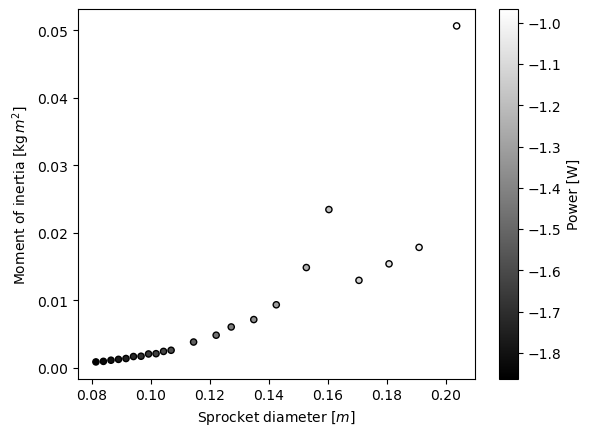

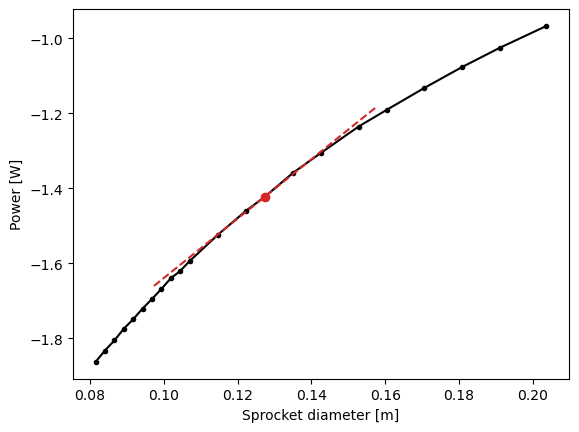

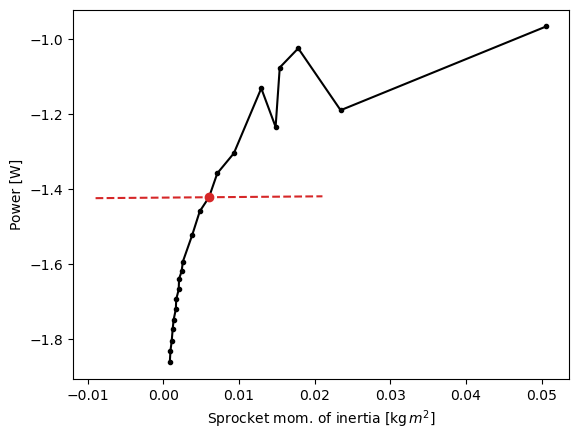

In [19]:
# diameter & MOI
plt.figure()

plt.scatter(spr_diameters, spr_moi, s=20, c=fvals, cmap='gray', edgecolors='0.0')
plt.xlabel('Sprocket diameter [$m$]')
plt.ylabel('Moment of inertia [$\operatorname{kg} m^2$]')
plt.colorbar(label='Power [W]')

plt.savefig('optimization_2.pdf')

# diameter
idx = 13  # index for default sprocket, when sorted by diameter

plt.figure()
plt.plot(spr_diameters, fvals, 'k.-')
plt.plot(spr_diameters[idx], fvals[idx], 'o', color='tab:red')
plt.plot()

dx = 0.03
x = np.array([spr_diameters[idx]-dx, spr_diameters[idx]+dx])
m = dP_dDs(*inputs)
b = fvals[idx] - m*spr_diameters[idx]
y = m*x + b

plt.plot(x, y, '--', color='tab:red')
plt.xlabel('Sprocket diameter [m]')
plt.ylabel('Power [W]')

plt.savefig('optimization.pdf')

# MOI
spr_moi_s =  sorted(spr_moi)
fvals_s = [x for _, x in sorted(zip(spr_moi, fvals))]
idx = 13  # index for default sprocket, when sorted by moment of inertia

plt.figure()
plt.plot(spr_moi_s, fvals_s, 'k.-')
plt.plot(spr_moi_s[idx], fvals_s[idx], 'o', color='tab:red')

dx = 0.015
x = np.array([spr_moi_s[idx]-dx, spr_moi_s[idx]+dx])
m = dP_dMs(*inputs)
b = fvals_s[idx] - m*spr_moi_s[idx]
y = m*x + b

plt.plot(x, y, '--', color='tab:red')
plt.xlabel('Sprocket mom. of inertia [$\operatorname{kg} m^2$]')
plt.ylabel('Power [W]')
